# Random vs. Feedback Noise

Does the increasing FPR observed in experiments depend on the fact that we are using the model's predictions to perturb labels? What if we just randomly perturb labels during training according to a model's initial FPR? Would the same increase in FPR be observed?

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import importlib
import utils
importlib.reload(utils)

from utils import eval_model, perturb_labels_fp, update_model_noise, update_model_feedback, make_gaussian_data

%matplotlib inline

In [7]:
def train_update_loop(n_train, n_update, n_test, num_updates, data_fn, seeds):
    seeds = np.arange(seeds)
    initial_fprs = []
    updated_fprs_noise = []
    updated_fprs_feedback = []

    for seed in seeds:
        np.random.seed(seed)

        x_train, y_train, x_update, y_update, x_test, y_test = data_fn(n_train, n_update, n_test)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        new_model_noise = update_model_noise(model, x_update, y_update, num_updates, initial_fpr)
        new_model_feedback, _ = update_model_feedback(model, x_update, y_update, x_test, y_test, num_updates)

        y_pred_noise = new_model_noise.predict(x_test)
        updated_tnr_noise, updated_fpr_noise, updated_fnr_noise, updated_tpr_noise = eval_model(y_test, y_pred_noise)

        y_pred_feedback = new_model_feedback.predict(x_test)
        updated_tnr_feedback, updated_fpr_feedback, updated_fnr_feedback, updated_tpr_feedback = eval_model(y_test, y_pred_feedback)

        initial_fprs.append(initial_fpr)
        updated_fprs_noise.append(updated_fpr_noise)
        updated_fprs_feedback.append(updated_fpr_feedback)
        
    return initial_fprs, updated_fprs_noise, updated_fprs_feedback

In [3]:
def generate_gaussian_data(n_train, n_update, n_test, noise=0.0):
    m0 = -1
    m1 = 1
    
    s0 = 1
    s1 = 1
    
    p0 = 0.5
    p1 = 1 - p0
    
    x_train, y_train = make_gaussian_data(m0, m1, s0, s1, n_train, p0, p1, features=2, noise=noise)

    x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=2)
    x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=2)

    return x_train, y_train, x_update, y_update, x_test, y_test

In [31]:
n_train = 1000
n_update = 10000
n_test = 50000

num_updates = 100
seeds = 1000
data_fn = generate_gaussian_data

In [32]:
initial_fprs, updated_fprs_noise, updated_fprs_feedback = train_update_loop(n_train, n_update, n_test, num_updates, data_fn, seeds)

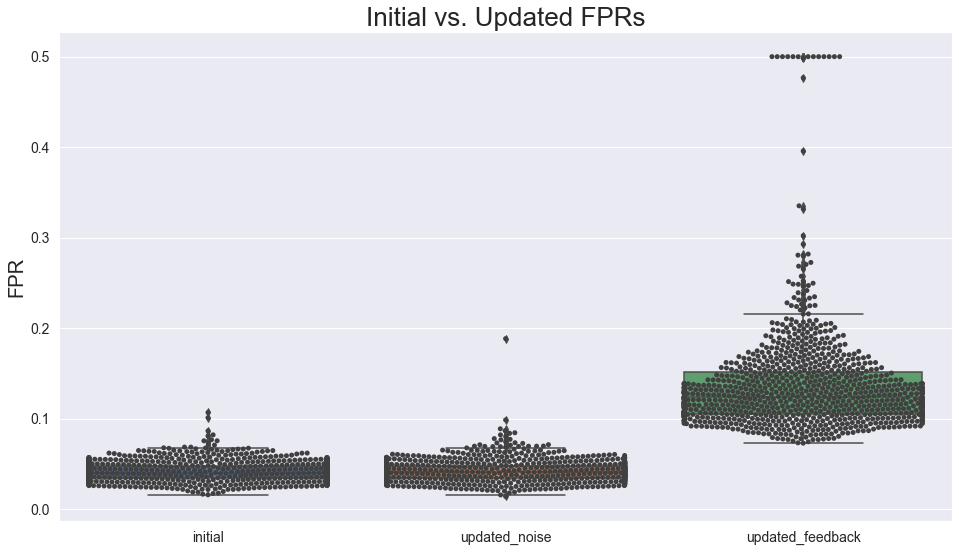

In [6]:
fprs_boxplot = {"type": (["initial"] * len(initial_fprs)) + (["updated_noise"] * len(updated_fprs_noise)) + (["updated_feedback"] * len(updated_fprs_feedback)),
        "fpr": initial_fprs + updated_fprs_noise + updated_fprs_feedback}
data_boxplot = pd.DataFrame(fprs_boxplot)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data_boxplot, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data_boxplot, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

In [20]:
sns.set_style("white")

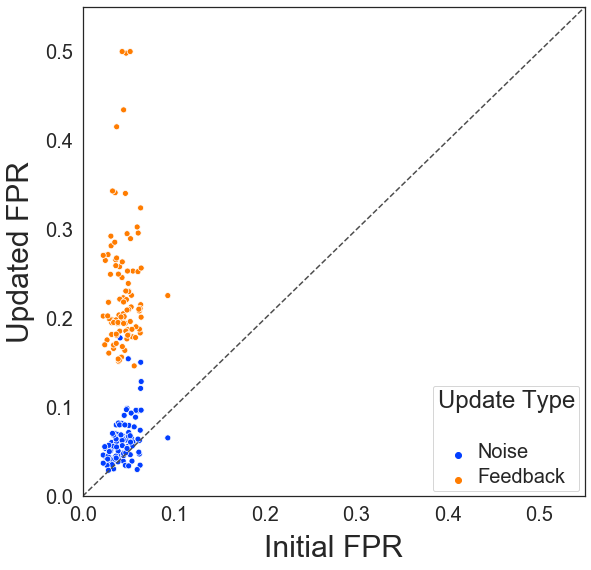

In [30]:
fprs_scatterplot = {"type": (["Noise"] * len(updated_fprs_noise)) + (["Feedback"] * len(updated_fprs_feedback)), "initial_fpr": initial_fprs + initial_fprs, "updated_fpr": updated_fprs_noise + updated_fprs_feedback}
data_scatterplot = pd.DataFrame(fprs_scatterplot)
max_fpr = max(fprs_scatterplot["initial_fpr"] + fprs_scatterplot["updated_fpr"])
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
g = sns.scatterplot(x="initial_fpr", y="updated_fpr", hue="type", data=data_scatterplot, ax=ax, legend="full", palette="bright")
ax.set_xlabel("Initial FPR", size=30, labelpad=10.0)
ax.set_ylabel("Updated FPR", size=30, labelpad=10.0)
ax.set_xlim([0, max_fpr + 0.05])
ax.set_ylim([0, max_fpr + 0.05])

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

legend = ax.legend(title="Update Type", title_fontsize=24, loc="lower right")
legend.texts[0].set_size(20)
legend.texts[0].set_visible(False)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

In [16]:
legend.texts

[Text(0, 0, 'Updated Noise'), Text(0, 0, 'Updated Feedback')]